In [6]:
import requests
import math
import matplotlib.pyplot as plt
import shutil
from PIL import Image, UnidentifiedImageError
from io import BytesIO
from pathlib import Path
import torch
from torchvision.datasets import ImageFolder

c:\Users\Marcel\AppData\Local\pypoetry\Cache\virtualenvs\iis-projekt-rI2k1HaH-py3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
term_1 = "Golden retriever" #@param {type:"string"}
term_2 = "German shepherd" #@param {type:"string"}
term_3 = "French bulldog" #@param {type:"string"}
term_4 = "Beagle" #@param {type:"string"}
term_5 = "Yorkshire Terrier" #@param {type:"string"}
term_6 = "Persian cat" #@param {type:"string"}
term_7 = "Siamese cat" #@param {type:"string"}
term_8 = "Spyhnx cat" #@param {type:"string"}
term_9 = "Maine Coon" #@param {type:"string"}
term_10 = "Parrot" #@param {type:"string"}
term_11 = "Gold fish" #@param {type:"string"}
term_12 = "Koi fish" #@param {type:"string"}

search_terms = sorted([
    term_1,
    term_2,
    term_3,
    term_4,
    term_5,
    term_6,
    term_7,
    term_8,
    term_9,
    term_10,
    term_11,
    term_12
])

search_terms = [x for x in search_terms if x.strip() != '']

In [8]:
SEARCH_URL = "https://huggingface.co/api/experimental/images/search"

def get_image_urls_by_term(search_term: str, count=150):
    params  = {"q": search_term, "license": "public", "imageType": "photo", "count": count}
    response = requests.get(SEARCH_URL, params=params)
    response.raise_for_status()
    response_data = response.json()
    image_urls = [img['thumbnailUrl'] for img in response_data['value']]
    return image_urls


def gen_images_from_urls(urls):
    num_skipped = 0
    for url in urls:
        response = requests.get(url)
        if not response.status_code == 200:
            num_skipped += 1
        try:
            img = Image.open(BytesIO(response.content))
            yield img
        except UnidentifiedImageError:
            num_skipped +=1

    print(f"Retrieved {len(urls) - num_skipped} images. Skipped {num_skipped}.")


def urls_to_image_folder(urls, save_directory):
    for i, image in enumerate(gen_images_from_urls(urls)):
        image.save(save_directory / f'{i}.jpg')

In [9]:
data_dir = Path('../../data/images')

if data_dir.exists():
    shutil.rmtree(data_dir)

for search_term in search_terms:
    search_term_dir = data_dir / search_term
    search_term_dir.mkdir(exist_ok=True, parents=True)
    urls = get_image_urls_by_term(search_term)
    print(f"Saving images of {search_term} to {str(search_term_dir)}...")
    urls_to_image_folder(urls, search_term_dir)

Saving images of Beagle to ..\..\data\images\Beagle...
Retrieved 150 images. Skipped 0.
Saving images of French bulldog to ..\..\data\images\French bulldog...
Retrieved 144 images. Skipped 0.
Saving images of German shepherd to ..\..\data\images\German shepherd...
Retrieved 149 images. Skipped 0.
Saving images of Gold fish to ..\..\data\images\Gold fish...
Retrieved 147 images. Skipped 0.
Saving images of Golden retriever to ..\..\data\images\Golden retriever...
Retrieved 150 images. Skipped 0.
Saving images of Koi fish to ..\..\data\images\Koi fish...
Retrieved 150 images. Skipped 0.
Saving images of Maine Coon to ..\..\data\images\Maine Coon...
Retrieved 146 images. Skipped 0.
Saving images of Parrot to ..\..\data\images\Parrot...
Retrieved 150 images. Skipped 0.
Saving images of Persian cat to ..\..\data\images\Persian cat...
Retrieved 149 images. Skipped 0.
Saving images of Siamese cat to ..\..\data\images\Siamese cat...
Retrieved 148 images. Skipped 0.
Saving images of Spyhnx cat 

In [10]:
ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .15)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

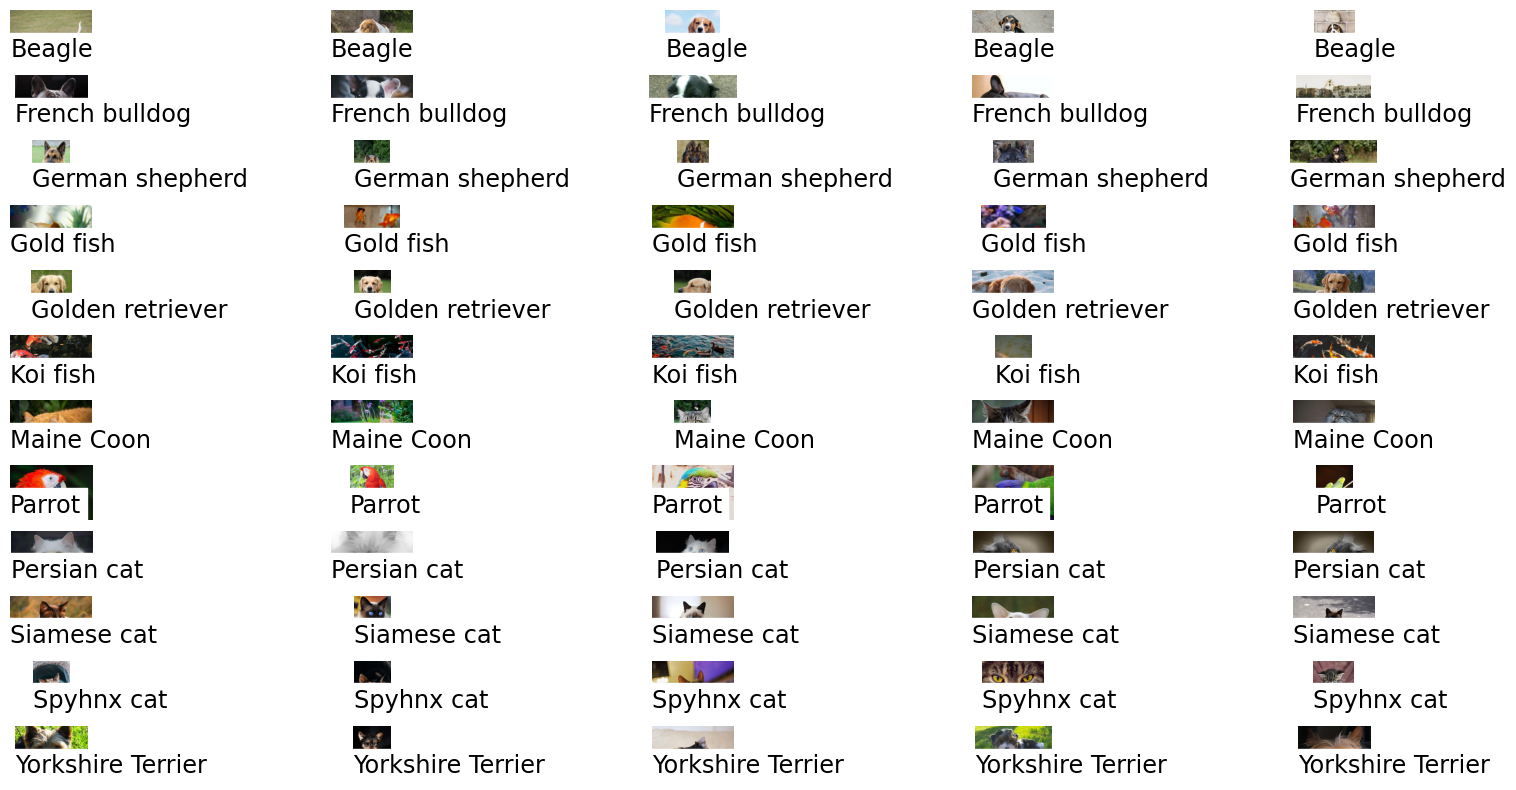

In [11]:
plt.figure(figsize=(20,10))
num_examples_per_class = 5
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

In [12]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [13]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
 
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings 

***
### Colab link
https://colab.research.google.com/github/nateraw/huggingpics/blob/main/HuggingPics.ipynb#scrollTo=tDfUUwH73LSq